# 2021-12-21 Update Note

- Being discouraged by the low performance of transformer, and research, I will move back to "more" epoch.

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


- I will use xresnet and their datablock, optimizer from fastai.

In [1]:
!git clone https://github.com/fastai/course-v3/ /content/course-v3

Cloning into '/content/course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.10 MiB | 13.75 MiB/s, done.
Resolving deltas: 100% (3251/3251), done.


In [5]:
# restart-run
%cd /content/course-v3/nbs/dl2

/content/course-v3/nbs/dl2


- NOTE: if you do not have installed [nvidia/apex](https://github.com/nvidia/apex),  change `from exp.nb_10c import *` to `from exp.nb_10b import *` in `exp.nb_11`

In [6]:
from exp.nb_12a import *

- Local data (which is divided into separate dataset) is saved to `Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser'`


In [7]:
root_path = Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1'); root_path.ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/dev')]

features-entry contains a list of a list with 26 items.
- length of inner list: 26 (float numbers - represent one preprocessed speech frame (logMel))

- length of outer list: number of frames per data-point, e.g. 10 or 15, ...

In [9]:
train_path = root_path/'train'

In [10]:
# restart-run
audios = get_files(train_path)
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)
        
al=AudioList.from_files(train_path); al

AudioList (7800 items)
[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train/7760_1_1.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train/7761_0_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train/7762_0_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train/7763_1_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train/7764_1_1.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train/7765_1_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train/7766_1_1.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train/7767_1_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train/7768_1_0.p

In [11]:
al[0].shape, al[0].type()

(torch.Size([614, 26]), 'torch.FloatTensor')

In [12]:
class ToCuda():
    _order=10
    def __call__(self, ad):
        return ad.cuda()

In [13]:
class Reshape():
    _order=12
    def __call__(self, item):
        w, h = item.shape
        return item.view(h, w)

In [54]:
# Mutants of input tensor
class PadorTrim():
    
    _order = 20
    def __init__(self, max_len):
        self.max_len = max_len
    def __call__(self, ad):
        # h - logmel, here 27, w - frames / various
        h, w = ad.shape
        pad_size = self.max_len - w
        if pad_size >0: return torch.cat((ad, torch.zeros(h, pad_size).to(ad.device)), dim=1)
        else: return ad[:, :self.max_len]

In [15]:
class DummyChannel():
    _order = 30
    def __call__(self, item):
        return item.unsqueeze(0)

In [16]:
tfms = [ToCuda(), Reshape(), PadorTrim(250), DummyChannel()]
compose(al[0], tfms).shape

torch.Size([1, 26, 250])

In [17]:
al=AudioList.from_files(train_path, tfms=tfms)

In [18]:
def re_labeler(fn, pat, subcl='act'):
    assert subcl in ['act', 'val', 'all']
    if subcl=='all': return ''.join(re.findall(pat, str(fn)))
    else:
        return re.findall(pat, str(fn))[0] if pat == 'act' else re.findall(pat, str(fn))[1]

label_pat = r'_(\d+)'
emotion_labeler = partial(re_labeler, pat=label_pat, subcl='all')

In [19]:
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [20]:
bs=64
c_in = ll.train[0][0].shape[0]
c_out = len(uniqueify(ll.train.y))
data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

In [21]:
ll.train[0][0].shape

torch.Size([1, 26, 250])

In [22]:
c_in, c_out

(1, 4)

In [23]:
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-1, )
loss_func = LabelSmoothingCrossEntropy()
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85, 0.95))
cbscheds = [ParamScheduler('lr', sched_lr), 
            ParamScheduler('mom', sched_mom)]

In [24]:
learn = cnn_learner(xresnet50, data, loss_func, opt_func)

In [84]:
learn.fit(30, cbs=cbscheds)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.331281,0.437038,1.234124,0.438374,00:23
1,1.222390,0.461773,1.317702,0.426302,00:23
2,1.206245,0.465467,1.215294,0.440915,00:23
3,1.198860,0.461773,1.194809,0.470140,00:23
4,1.196813,0.469804,1.184216,0.479670,00:23
5,1.218045,0.475426,1.200587,0.477128,00:23
6,1.188055,0.477674,1.208302,0.451715,00:23
7,1.187711,0.478317,1.206676,0.457433,00:23
8,1.182942,0.476550,1.348407,0.425032,00:23
9,1.175299,0.487632,1.509804,0.429479,00:23


In [ ]:
learn.fit(30, cbs=cbscheds)

In [77]:
def save_checkpoint(learner, filename):
    fname = Path(filename)
    fname.parent.mkdir(parents=True, exist_ok = True)
    checkpoint_dict = {
        'model': learn.model.state_dict(),
    }
    torch.save(checkpoint_dict, fname)

In [85]:
save_checkpoint(learn, '/content/checkpoints/xtesnet50-20epochs.pt')

---

# Let me save the best model
1. measure metric and reserve the max values
2. when the max value changes, change the checkpoint model

In [127]:
def get_predictions(learn):
    learn.model.eval()
    targets, outputs = [],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.data.valid_dl):
            out = learn.model(xb)
            for _,y,z in zip(xb,yb,out):
                targets.append(learn.data.train_ds.proc_y.deproc1(y))
                outputs.append(learn.data.train_ds.proc_y.deproc1(z.argmax(-1)))
    return targets, outputs

In [129]:
trg, pred = get_predictions(learn)

In [ ]:
class MultiLabelFscore():
    def __init__(self, id2mult):
        "here the y label will change from single label to multi label"
        self.id2mult = id2mult
    def __call__(self, pred, targ):
        # return activation, valence fscore
        preds = np.array([self.id2mult[p] for p in pred])
        targets = np.array([self.id2mult[p] for p in targ])
        return f1_score(targets[:, 0], preds[:, 0]), f1_score(targets[:, 1], preds[:, 1])

In [131]:
label_dicts = {0:(1, 1), 2:(0, 0), 2:(1,0), 3:(0, 1)}

In [132]:
from sklearn.metrics import confusion_matrix

In [138]:
%cd /content

/content


In [211]:
import seaborn as sn
import pandas as pd

In [223]:
from IPython.display import display,HTML

In [226]:
def cm(true_label, pred_label, clf):
    """
    The function not only calculates confusion matrix, but also visualizes (i.e. sys out write) it as heatmap
    Parameters
    ----------
    true_label : array-like of shape (n_samples,)
        Ground truth of target data
    pred_label : array-like of shape (n_samples,)
        Predictoin from target data
    labels: array-like of shape (n_classes), default=None
        labels which index confusion matrix
    Note
    ----------
    Please be sure that input is 1-D
    """
    cm_score = confusion_matrix(true_label, pred_label)
    df_cm = pd.DataFrame(cm_score, index=clf.labels, columns=clf.labels)
    display(HTML(df_cm.to_html()))

    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    img_path = Path('/content/results/cm')
    img_path.mkdir(exist_ok=True, parents=True)
    fname = img_path / f'ser_{clf.model.name}_epochs:{clf.epochs}'
    plt.savefig(fname)
    print(f"Your confusion matrix is saved at : {str(img_path)} named {fname}")

,"(act:0, val:1)","(act:0, val:0)","(act:1, val:1)","(act:1, val:0)"
"(act:0, val:1)",92,45,45,77
"(act:0, val:0)",42,39,24,96
"(act:1, val:1)",37,47,351,215
"(act:1, val:0)",37,47,138,242


Your confusion matrix is saved at : /content/results/cm named /content/results/cm/ser_xresnet50_epochs:30


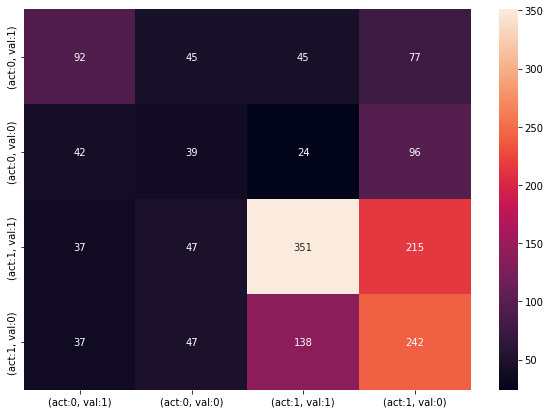

In [227]:
cm(trg, pred, learn)

In [213]:
learn.model.name = 'xresnet50'

In [135]:
learn.labels = {'(act:1, val:1)','(act:0, val:0)', '(act:1, val:0)', '(act:0, val:1)'}

In [149]:
from sklearn.metrics import classification_report

In [151]:
print(classification_report(trg, pred))

              precision    recall  f1-score   support

          00       0.44      0.36      0.39       259
          01       0.22      0.19      0.21       201
          10       0.63      0.54      0.58       650
          11       0.38      0.52      0.44       464

    accuracy                           0.46      1574
   macro avg       0.42      0.40      0.41      1574
weighted avg       0.47      0.46      0.46      1574



In [154]:
import numpy as np

In [164]:
# y0: activation, y1: valence
trg_collection = np.array([[int(y[0]), int(y[1])] for y in trg])

In [167]:
true_act = trg_collection[:, 0]
true_val = trg_collection[:, 1]

In [166]:
pred_collection = np.array([[int(y[0]), int(y[1])] for y in pred])
pred_act, pred_val = pred_collection[:, 0], pred_collection[:, 1]

In [238]:
from sklearn.metrics import f1_score


0.8218940052128584

In [202]:
print(classification_report(true_act, pred_act))

              precision    recall  f1-score   support

           0       0.56      0.47      0.52       460
           1       0.80      0.85      0.82      1114

    accuracy                           0.74      1574
   macro avg       0.68      0.66      0.67      1574
weighted avg       0.73      0.74      0.73      1574



In [203]:
print(classification_report(true_val, pred_val))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       909
           1       0.52      0.64      0.58       665

    accuracy                           0.60      1574
   macro avg       0.61      0.61      0.60      1574
weighted avg       0.62      0.60      0.61      1574



In [192]:
show_resource(accuracy)

def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()



In [240]:
(f1_score(true_act, pred_act) + f1_score(true_val, pred_val))/2

0.69879493200222

In [231]:
(root_path.parent.parent/'checkpoints').ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/v2.1.pkl'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/.ipynb_checkpoints')]

In [237]:
(root_path.parent.parent/'interpret').mkdir()

In [232]:
model_path = root_path.parent.parent/'checkpoints'

In [234]:
!cp /content/checkpoints/*.pt {str(model_path)}/.

In [235]:
!ls {model_path}

v2.1.pkl  xtesnet34-20epochs.pt  xtesnet50-20epochs.pt


# submission - load and predict

In [25]:
path2= Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/')
upload_path =path2/'uploads'
upload_path.mkdir(exist_ok=True)

In [55]:
tfms = [Reshape(), PadorTrim(250), DummyChannel()]

In [35]:
st = torch.load('/content/checkpoints/xtesnet50-20epochs-f1:0.698.pt')

In [36]:
st.keys()

dict_keys(['model'])

In [37]:
learn.model.load_state_dict(st['model'])

<All keys matched successfully>

In [56]:
dev_path = (path2/'data/v1/dev')
# audios = get_files(dev_path)
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)
        
al=AudioList.from_files(dev_path, tfms=tfms)

In [58]:
testset=torch.cat([al[idx] for idx, _ in enumerate(al.items)], dim=0)
testset.shape

torch.Size([3342, 26, 250])

In [108]:
def get_predictions(learn, dev):
    test_n = dev.shape[0]
    learn.model.eval()
    res = []
    with torch.no_grad():        
        for i in range((test_n-1)//bs + 1):
            xb = dev[i*bs:(i+1)*bs]
            out = learn.model(xb)
            res += [o.item() for o in out.argmax(1)]
    return res

In [109]:
res = get_predictions(learn, testset.unsqueeze(1))

In [110]:
len(res)

3342

In [95]:
ser_path  =Path("/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/")

In [116]:
(ser_path).exists()

True

In [100]:
import json
with open(ser_path/'data/v0/ser-dev.json') as f: dev_json = json.load(f)

In [101]:
len(dev_json)

3342

In [155]:
(ser_path/'checkpoints').ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/v2.1.pkl'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/.ipynb_checkpoints'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet34-20epochs.pt'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet50-20epochs-f1:0.698.pt')]

In [156]:
!cp '/content/checkpoints/xtesnet50-20epochs-698f1score.pt' /gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints

cp: cannot stat '/content/checkpoints/xtesnet50-20epochs-698f1score.pt': No such file or directory


---

# Converting the format

In [137]:
def get_serial(): return ''.join(str(i) for i in np.random.randint(0, 9, 10).tolist())

In [138]:
my_serial = get_serial()

In [130]:
label_dicts = {0:(1, 1), 1:(0, 0), 2:(1,0), 3:(0, 1)}

In [132]:
res_dict = {str(i): label_dicts[o] for i, o in enumerate(res)}